In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]=""
%load_ext autoreload
%autoreload 2

In [2]:
import edesdetectrl.config as general_config
from mlflow.tracking import MlflowClient
import mlflow

client1 = MlflowClient(general_config.config["mlflow"]["tracking_uri"])
client2= MlflowClient("/itf-fi-ml/home/magnukva/mlflow")

In [3]:
# Color palette
pink = "#FF00C0"
purple = "#9401FF"
dark_blue = "#4900FF"
blue = "#01B9FF"
cyan = "#00FFF9"

In [4]:

def get_info(run_id):
    try:
        params = client2.get_run(run_id).data.params
    except:
        params = client1.get_run(run_id).data.params
    return params["reward_spec"], params["epsilon"]

run_ids = [
    "43f53b9f46824eaaa4cd76b90c8fa114",
    "8a21d317474247c6a5826a82b8a9b15f",
    "84e1fbe39c544e49ac0e76df36b8db59",
    "4038c10f7fd641f0a585f59db3f8d926",
    "f4b9cc5f9e7543cb9b1feec1ce378a2f",  # "722591f19abc4e4d8e003b718a026771",
    "e32848d70385456294e7921ce6bb77ea",
]

{id:get_info(id) for id in run_ids}

{'43f53b9f46824eaaa4cd76b90c8fa114': ('proximity', '0.5'),
 '8a21d317474247c6a5826a82b8a9b15f': ('simple', '0.5'),
 '84e1fbe39c544e49ac0e76df36b8db59': ('simple', '1.0'),
 '4038c10f7fd641f0a585f59db3f8d926': ('simple', '0.1'),
 'f4b9cc5f9e7543cb9b1feec1ce378a2f': ('proximity', '0.1'),
 'e32848d70385456294e7921ce6bb77ea': ('proximity', '1.0')}

# Plots
- Compare learning curves
    - Simple reward function GaaFD, Balanced Accuracy, GaaFD overfitting (3 cols)
    - Proximity reward function GaaFD, Balanced Accuracy, GaaFD overfitting (3 cols)
    - Simple reward and Promixity reward loss
    - GaaFD and Balanced Accuracy, simple reward vs proximity reward for each epsilon (2 rows, 3 cols)


In [50]:
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
import numpy as np

# 0.1, 0.5, 1.0
simple_reward_run_ids = [
    "4038c10f7fd641f0a585f59db3f8d926",
    "8a21d317474247c6a5826a82b8a9b15f",
    "84e1fbe39c544e49ac0e76df36b8db59",
]

# 0.1, 0.5, 1.0
proximity_reward_run_ids = [
    "f4b9cc5f9e7543cb9b1feec1ce378a2f",
    "43f53b9f46824eaaa4cd76b90c8fa114",
    "e32848d70385456294e7921ce6bb77ea",
]

# 0.1, 0.5, 1.0
colors = [pink, dark_blue, blue]


def get_metrics(run_id, name, max_steps, sigma=15):
    if run_id == "f4b9cc5f9e7543cb9b1feec1ce378a2f":
        sigma /= 15
    try:
        hist = client2.get_metric_history(run_id, name)
    except:
        hist = client1.get_metric_history(run_id, name)
    hist = [m for m in hist if m.step <= max_steps]
    steps = [m.step for m in hist]
    values = [m.value for m in hist]
    values = gaussian_filter1d(values, sigma)
    return steps, values


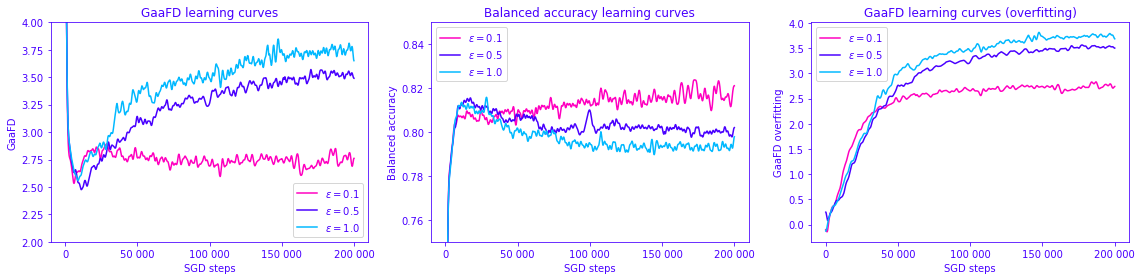

In [6]:
fig, ax = plt.subplots(ncols=3, figsize=(16, 4))
for run_id, color in zip(simple_reward_run_ids, colors):
    val_steps, val_values = get_metrics(run_id, "VAL_gaafd", 200_000)
    ax[0].plot(val_steps, val_values, c=color)
    train_steps, train_values = get_metrics(run_id, "TRAIN_gaafd", 200_000)
    diff = val_values - np.interp(val_steps, train_steps, train_values)
    diff = gaussian_filter1d(diff, 10)
    ax[2].plot(val_steps, diff, c=color)

    steps, values = get_metrics(run_id, "VAL_balanced_accuracy", 200_000)
    ax[1].plot(steps, values, c=color)

ax[0].set_title("GaaFD learning curves", c=dark_blue)
ax[0].set_ylabel("GaaFD", c=dark_blue)
ax[0].set_xlabel("SGD steps", c=dark_blue)
ax[0].legend(
    ["$\epsilon =0.1$", "$\epsilon =0.5$", "$\epsilon =1.0$"], labelcolor=dark_blue
)
ax[0].set_ylim([2, 4])
ax[1].set_title("Balanced accuracy learning curves", c=dark_blue)
ax[1].set_ylabel("Balanced accuracy", c=dark_blue)
ax[1].set_xlabel("SGD steps", c=dark_blue)
ax[1].legend(
    ["$\epsilon =0.1$", "$\epsilon =0.5$", "$\epsilon =1.0$"], labelcolor=dark_blue
)
ax[1].set_ylim([0.75, 0.85])
ax[2].set_title("GaaFD learning curves (overfitting)", c=dark_blue)
ax[2].set_ylabel("GaaFD overfitting", c=dark_blue)
ax[2].set_xlabel("SGD steps", c=dark_blue)
ax[2].legend(
    ["$\epsilon =0.1$", "$\epsilon =0.5$", "$\epsilon =1.0$"], labelcolor=dark_blue
)


for ax in fig.axes:
    ax.tick_params(color=dark_blue, labelcolor=dark_blue)
    ax.set_xticks(
        [0, 50e3, 100e3, 150e3, 200e3],
        ["0", "50 000", "100 000", "150 000", "200 000"],
    )
    for spine in ax.spines.values():
        spine.set_edgecolor(dark_blue)
fig.tight_layout()

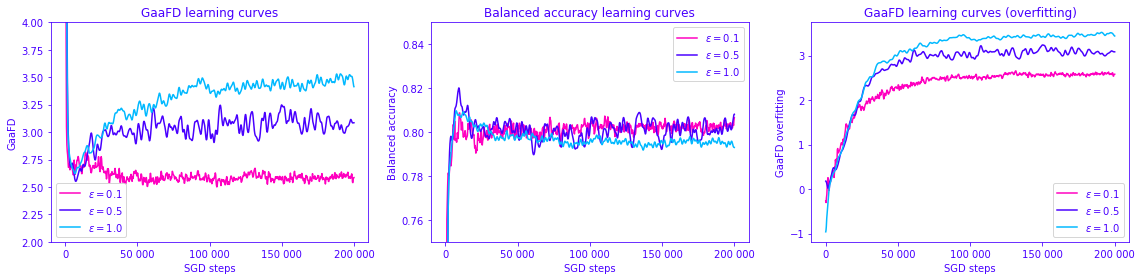

In [10]:
fig, ax = plt.subplots(ncols=3, figsize=(16, 4))
for run_id, color in zip(proximity_reward_run_ids, colors):
    val_steps, val_values = get_metrics(run_id, "VAL_gaafd", 200_000)
    ax[0].plot(val_steps, val_values, c=color)
    train_steps, train_values = get_metrics(run_id, "TRAIN_gaafd", 200_000)
    diff = val_values - np.interp(val_steps, train_steps, train_values)
    diff = gaussian_filter1d(diff, 0.1 if run_id=="f4b9cc5f9e7543cb9b1feec1ce378a2f" else 10)
    ax[2].plot(val_steps, diff, c=color)

    steps, values = get_metrics(run_id, "VAL_balanced_accuracy", 200_000)
    ax[1].plot(steps, values, c=color)

ax[0].set_title("GaaFD learning curves", c=dark_blue)
ax[0].set_ylabel("GaaFD", c=dark_blue)
ax[0].set_xlabel("SGD steps", c=dark_blue)
ax[0].legend(
    ["$\epsilon =0.1$", "$\epsilon =0.5$", "$\epsilon =1.0$"], labelcolor=dark_blue
)
ax[0].set_ylim([2, 4])
ax[1].set_title("Balanced accuracy learning curves", c=dark_blue)
ax[1].set_ylabel("Balanced accuracy", c=dark_blue)
ax[1].set_xlabel("SGD steps", c=dark_blue)
ax[1].legend(
    ["$\epsilon =0.1$", "$\epsilon =0.5$", "$\epsilon =1.0$"], labelcolor=dark_blue
)
ax[1].set_ylim([0.75, 0.85])
ax[2].set_title("GaaFD learning curves (overfitting)", c=dark_blue)
ax[2].set_ylabel("GaaFD overfitting", c=dark_blue)
ax[2].set_xlabel("SGD steps", c=dark_blue)
ax[2].legend(
    ["$\epsilon =0.1$", "$\epsilon =0.5$", "$\epsilon =1.0$"], labelcolor=dark_blue
)

for ax in fig.axes:
    ax.tick_params(color=dark_blue, labelcolor=dark_blue)
    ax.set_xticks(
        [0, 50e3, 100e3, 150e3, 200e3],
        ["0", "50 000", "100 000", "150 000", "200 000"],
    )
    for spine in ax.spines.values():
        spine.set_edgecolor(dark_blue)
fig.tight_layout()

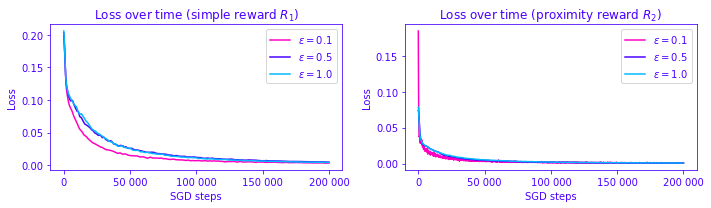

In [19]:
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
import numpy as np

fig, ax = plt.subplots(ncols=2, figsize=(10, 3))
max_steps=200_000
for run_id, color in zip(simple_reward_run_ids, colors):
    val_steps, val_values = get_metrics(run_id, "total_loss", max_steps)
    ax[0].plot(val_steps, val_values, c=color)
for run_id, color in zip(proximity_reward_run_ids, colors):
    val_steps, val_values = get_metrics(run_id, "total_loss", max_steps)
    ax[1].plot(val_steps, val_values, c=color)

ax[0].set_title("Loss over time (simple reward $R_1$)", c=dark_blue)
ax[0].set_ylabel("Loss", c=dark_blue)
ax[0].set_xlabel("SGD steps", c=dark_blue)
ax[0].legend(
    ["$\epsilon =0.1$", "$\epsilon =0.5$", "$\epsilon =1.0$"], labelcolor=dark_blue
)
ax[1].set_title("Loss over time (proximity reward $R_2$)", c=dark_blue)
ax[1].set_ylabel("Loss", c=dark_blue)
ax[1].set_xlabel("SGD steps", c=dark_blue)
ax[1].legend(
    ["$\epsilon =0.1$", "$\epsilon =0.5$", "$\epsilon =1.0$"], labelcolor=dark_blue
)

for ax in fig.axes:
    ax.tick_params(color=dark_blue, labelcolor=dark_blue)
    ax.set_xticks(
        [0, 50e3, 100e3, 150e3, 200e3],
        ["0", "50 000", "100 000", "150 000", "200 000"],
    )
    for spine in ax.spines.values():
        spine.set_edgecolor(dark_blue)
fig.tight_layout()


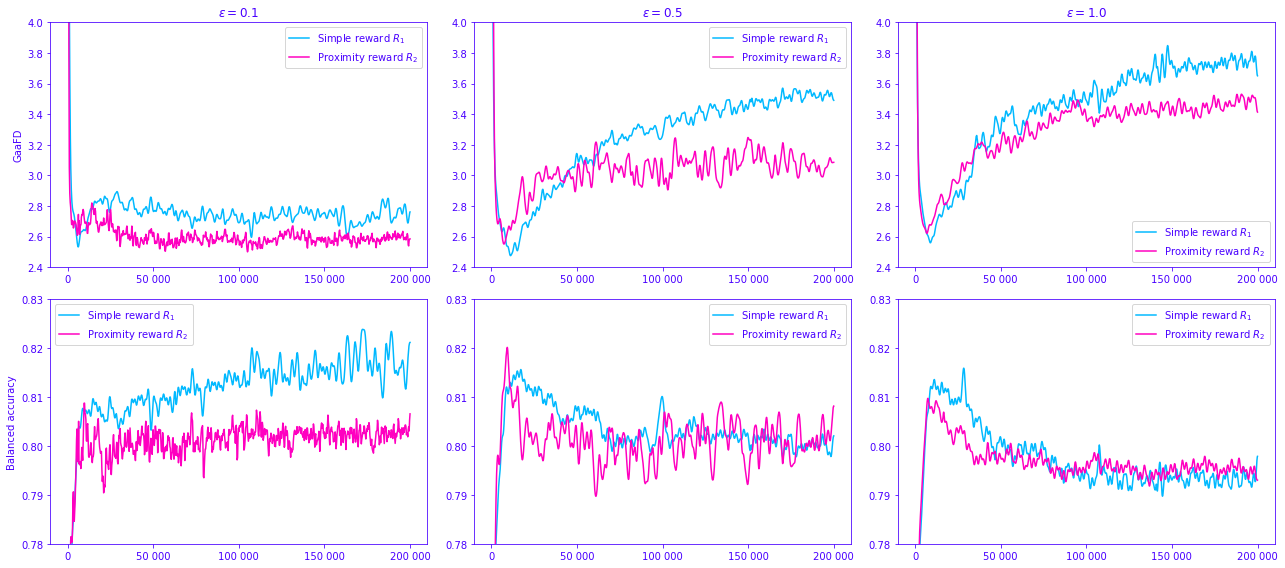

In [23]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(18, 8))

for col_i, (sr_id, pr_id, color) in enumerate(
    zip(simple_reward_run_ids, proximity_reward_run_ids, colors)
):
    sr_gaafd_steps, sr_gaafd_values = get_metrics(sr_id, "VAL_gaafd", 200_000)
    pr_gaafd_steps, pr_gaafd_values = get_metrics(pr_id, "VAL_gaafd", 200_000)
    sr_ba_steps, sr_ba_values = get_metrics(sr_id, "VAL_balanced_accuracy", 200_000)
    pr_ba_steps, pr_ba_values = get_metrics(pr_id, "VAL_balanced_accuracy", 200_000)
    ax[0, col_i].plot(sr_gaafd_steps, sr_gaafd_values, c=blue)
    ax[0, col_i].plot(pr_gaafd_steps, pr_gaafd_values, c=pink)
    ax[1, col_i].plot(sr_ba_steps, sr_ba_values, c=blue)
    ax[1, col_i].plot(pr_ba_steps, pr_ba_values, c=pink)

    ax[0, col_i].set_ylim([2.4, 4])
    ax[1, col_i].set_ylim([0.78, 0.83])
    ax[0, col_i].legend(
        ["Simple reward $R_1$", "Proximity reward $R_2$"], labelcolor=dark_blue
    )
    ax[1, col_i].legend(
        ["Simple reward $R_1$", "Proximity reward $R_2$"], labelcolor=dark_blue
    )


ax[0, 0].set_ylabel("GaaFD", c=dark_blue)
ax[1, 0].set_ylabel("Balanced accuracy", c=dark_blue)
ax[0, 0].set_title("$\epsilon =0.1$", c=dark_blue)
ax[0, 1].set_title("$\epsilon =0.5$", c=dark_blue)
ax[0, 2].set_title("$\epsilon =1.0$", c=dark_blue)

for ax in fig.axes:
    ax.tick_params(color=dark_blue, labelcolor=dark_blue)
    ax.set_xticks(
        [0, 50e3, 100e3, 150e3, 200e3],
        ["0", "50 000", "100 000", "150 000", "200 000"],
    )
    for spine in ax.spines.values():
        spine.set_edgecolor(dark_blue)
fig.tight_layout()

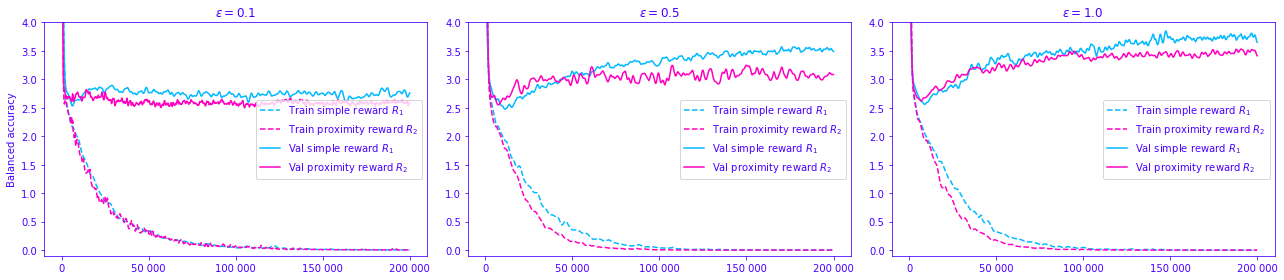

In [56]:
fig, ax = plt.subplots(ncols=3, figsize=(18, 4))

for col_i, (sr_id, pr_id, color) in enumerate(
    zip(simple_reward_run_ids, proximity_reward_run_ids, colors)
):
    train_sr_gaafd_steps, train_sr_gaafd_values = get_metrics(sr_id, "TRAIN_gaafd", 200_000)
    train_pr_gaafd_steps, train_pr_gaafd_values = get_metrics(pr_id, "TRAIN_gaafd", 200_000)
    ax[col_i].plot(train_sr_gaafd_steps, train_sr_gaafd_values, linestyle="dashed", c=blue)
    ax[col_i].plot(train_pr_gaafd_steps, train_pr_gaafd_values, linestyle="dashed", c=pink)
    val_sr_gaafd_steps, val_sr_gaafd_values = get_metrics(sr_id, "VAL_gaafd", 200_000)
    val_pr_gaafd_steps, val_pr_gaafd_values = get_metrics(pr_id, "VAL_gaafd", 200_000)
    ax[col_i].plot(val_sr_gaafd_steps, val_sr_gaafd_values, c=blue)
    ax[col_i].plot(val_pr_gaafd_steps, val_pr_gaafd_values, c=pink)

    ax[col_i].set_ylim([-0.1, 4])
    ax[col_i].legend(
        ["Train simple reward $R_1$", "Train proximity reward $R_2$", "Val simple reward $R_1$", "Val proximity reward $R_2$"], labelcolor=dark_blue
    )
    ax[col_i].legend(
        ["Train simple reward $R_1$", "Train proximity reward $R_2$", "Val simple reward $R_1$", "Val proximity reward $R_2$"], labelcolor=dark_blue
    )


ax[0].set_ylabel("GaaFD", c=dark_blue)
ax[0].set_ylabel("Balanced accuracy", c=dark_blue)
ax[0].set_title("$\epsilon =0.1$", c=dark_blue)
ax[1].set_title("$\epsilon =0.5$", c=dark_blue)
ax[2].set_title("$\epsilon =1.0$", c=dark_blue)

for ax in fig.axes:
    ax.tick_params(color=dark_blue, labelcolor=dark_blue)
    ax.set_xticks(
        [0, 50e3, 100e3, 150e3, 200e3],
        ["0", "50 000", "100 000", "150 000", "200 000"],
    )
    for spine in ax.spines.values():
        spine.set_edgecolor(dark_blue)
fig.tight_layout()

# Get best model for each $\epsilon$ and reward $R$

{'4038c10f7fd641f0a585f59db3f8d926': 6220,
 '8a21d317474247c6a5826a82b8a9b15f': 10960,
 '84e1fbe39c544e49ac0e76df36b8db59': 8964,
 'f4b9cc5f9e7543cb9b1feec1ce378a2f': 107936,
 '43f53b9f46824eaaa4cd76b90c8fa114': 6880,
 'e32848d70385456294e7921ce6bb77ea': 7096}

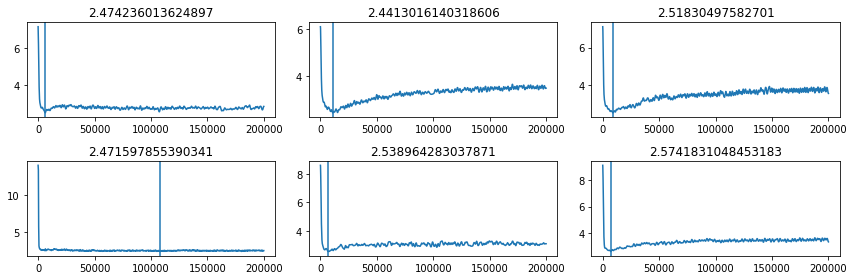

In [64]:
# Find the best model for each run
simple_reward_run_ids
proximity_reward_run_ids


fig, ax = plt.subplots(nrows = 2, ncols=3, figsize=(12, 4))
best_model_steps = {}
for i, run_id in enumerate(simple_reward_run_ids):
    val_steps, val_values = get_metrics(run_id, "VAL_gaafd", 200_000, sigma=10)
    best_model_i = np.argmin(val_values)
    best_model_steps[run_id] = val_steps[best_model_i]
    ax[0, i].axvline(val_steps[best_model_i])
    ax[0, i].plot(val_steps, val_values)
    ax[0, i].set_title(val_values[best_model_i])
for i, run_id in enumerate(proximity_reward_run_ids):
    val_steps, val_values = get_metrics(run_id, "VAL_gaafd", 200_000, sigma=10)
    best_model_i = np.argmin(val_values)
    best_model_steps[run_id] = val_steps[best_model_i]
    ax[1, i].axvline(val_steps[best_model_i])
    ax[1, i].plot(val_steps, val_values)
    ax[1, i].set_title(val_values[best_model_i])
fig.tight_layout()
best_model_steps

In [32]:
artifact_paths = {}
for run_id, best_model_step in best_model_steps.items():
    try:
        artifacts = client1.list_artifacts(run_id)
    except:
        artifacts = client2.list_artifacts(run_id)
    for artifact in artifacts:
        if artifact.path[7:] == str(best_model_step):
            artifact_paths[run_id]=artifact.path
            break
artifact_paths

{'4038c10f7fd641f0a585f59db3f8d926': 'params_6220',
 '8a21d317474247c6a5826a82b8a9b15f': 'params_10960',
 '84e1fbe39c544e49ac0e76df36b8db59': 'params_8964',
 'f4b9cc5f9e7543cb9b1feec1ce378a2f': 'params_107936',
 '43f53b9f46824eaaa4cd76b90c8fa114': 'params_6880',
 'e32848d70385456294e7921ce6bb77ea': 'params_7096'}

In [33]:
import notebooks.plots.results.bce.helpers as helpers
import pickle

train_trajectories = {} 
for run_id in artifact_paths.keys():
    params_path = "notebooks/plots/results/bce/r1r2_rewards/models/" + run_id
    train_trajectories[run_id] = helpers.evaluate_with_params(params_path, "TRAIN")

with open("train_trajectories", "wb+") as f:
    pickle.dump(train_trajectories, f)

test_trajectories = {} 
for run_id in artifact_paths.keys():
    params_path = "notebooks/plots/results/bce/r1r2_rewards/models/" + run_id
    test_trajectories[run_id] = helpers.evaluate_with_params(params_path, "TEST")

with open("test_trajectories", "wb+") as f:
    pickle.dump(test_trajectories, f)

100%|██████████| 1012/1012 [01:20<00:00, 12.52it/s]


In [39]:
import pickle

with open("notebooks/plots/results/bce/r1r2_rewards/trajectories/train_trajectories", "rb") as f:
    train_trajectories =pickle.load(f)
with open("notebooks/plots/results/bce/r1r2_rewards/trajectories/test_trajectories", "rb") as f:
    test_trajectories =pickle.load(f)

len(list(test_trajectories.values())[0]), len(list(train_trajectories.values())[0])


(937, 5466)

2.520158476054954
2.2372514148858826
2.520158476054954
2.2372514148858826
2.4634370076739343
1.9876355420812064
2.4634370076739343
1.9876355420812064
2.569131473293693
2.1100084927472413
2.569131473293693
2.1100084927472413


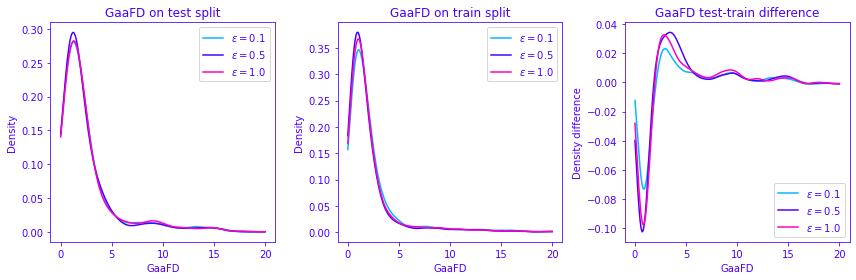

In [46]:
from edesdetectrl.environments import Trajectory, TrajectoryItem
from edesdetectrl.core.metrics import gaafd
from scipy import stats
import numpy as np
from typing import Dict, Tuple, List
import matplotlib.pyplot as plt


def gaafd_density(
    x: np.ndarray, trajectories: Dict[str, Tuple[List, List]], label=None, bw_method=None
):
    gaafds = []
    for filename, (gt, predictions) in trajectories.items():
        val = gaafd(gt, predictions, label=label)
        gaafds.append(val)
    density = stats.kde.gaussian_kde(gaafds, bw_method=bw_method)
    print(np.mean(gaafds))
    return density(x)

colors = [blue, dark_blue, pink]
x = np.linspace(0, 20, 200)
fig, ax = plt.subplots(ncols=3, figsize=(12, 4))

sr_test_traj = [test_trajectories[run_id] for run_id in simple_reward_run_ids]
sr_train_traj = [train_trajectories[run_id] for run_id in simple_reward_run_ids]
pr_test_traj = [test_trajectories[run_id] for run_id in proximity_reward_run_ids]
pr_train_traj = [train_trajectories[run_id] for run_id in proximity_reward_run_ids]

for i, (test_traj, train_traj) in enumerate(zip(sr_test_traj, sr_train_traj)):
    ax[0].plot(x, gaafd_density(x, test_traj, bw_method=None), c=colors[i])
    ax[1].plot(x, gaafd_density(x, train_traj, bw_method=None), c=colors[i])
    ax[2].plot(
        x, gaafd_density(x, test_traj, bw_method=None) - gaafd_density(x, train_traj, bw_method=None), c=colors[i]
    )

ax[0].set_title("GaaFD on test split", c=dark_blue)
ax[0].set_ylabel("Density", c=dark_blue)
ax[0].set_xlabel("GaaFD", c=dark_blue)
ax[0].legend(
    ["$\epsilon =0.1$", "$\epsilon =0.5$", "$\epsilon =1.0$"], labelcolor=dark_blue
)
ax[1].set_title("GaaFD on train split", c=dark_blue)
ax[1].set_ylabel("Density", c=dark_blue)
ax[1].set_xlabel("GaaFD", c=dark_blue)
ax[1].legend(
    ["$\epsilon =0.1$", "$\epsilon =0.5$", "$\epsilon =1.0$"], labelcolor=dark_blue
)
ax[2].set_title("GaaFD test-train difference", c=dark_blue)
ax[2].set_ylabel("Density difference", c=dark_blue)
ax[2].set_xlabel("GaaFD", c=dark_blue)
ax[2].legend(
    ["$\epsilon =0.1$", "$\epsilon =0.5$", "$\epsilon =1.0$"], labelcolor=dark_blue
)
#fig.suptitle("Gaussian kernel density estimate", c=dark_blue)
for ax in fig.axes:
    ax.tick_params(color=dark_blue, labelcolor=dark_blue)
    for spine in ax.spines.values():
        spine.set_edgecolor(dark_blue)
fig.tight_layout()


# GaaFD Scores
- $\epsilon=0.1$
  - TRAIN: 2.24
  - TEST: 2.52
- $\epsilon=0.5$
  - TRAIN: 1.99
  - TEST: 2.46
- $\epsilon=1.0$
  - TRAIN: 2.11
  - TEST: 2.57

2.5460042181226816
0.253304555143194
2.5460042181226816
0.253304555143194
2.5603805627551623
2.1632991657689793
2.5603805627551623
2.1632991657689793
2.630943602821938
2.1816599558915697
2.630943602821938
2.1816599558915697


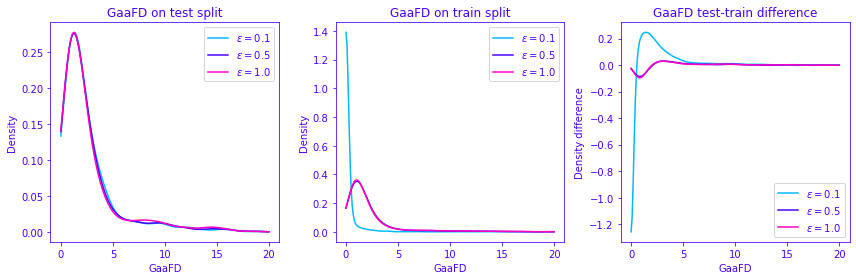

In [47]:
fig, ax = plt.subplots(ncols=3, figsize=(12, 4))
for i, (test_traj, train_traj) in enumerate(zip(pr_test_traj, pr_train_traj)):
    ax[0].plot(x, gaafd_density(x, test_traj, bw_method=None), c=colors[i])
    ax[1].plot(x, gaafd_density(x, train_traj, bw_method=None), c=colors[i])
    ax[2].plot(
        x, gaafd_density(x, test_traj, bw_method=None) - gaafd_density(x, train_traj, bw_method=None), c=colors[i]
    )

ax[0].set_title("GaaFD on test split", c=dark_blue)
ax[0].set_ylabel("Density", c=dark_blue)
ax[0].set_xlabel("GaaFD", c=dark_blue)
ax[0].legend(
    ["$\epsilon =0.1$", "$\epsilon =0.5$", "$\epsilon =1.0$"], labelcolor=dark_blue
)
ax[1].set_title("GaaFD on train split", c=dark_blue)
ax[1].set_ylabel("Density", c=dark_blue)
ax[1].set_xlabel("GaaFD", c=dark_blue)
ax[1].legend(
    ["$\epsilon =0.1$", "$\epsilon =0.5$", "$\epsilon =1.0$"], labelcolor=dark_blue
)
ax[2].set_title("GaaFD test-train difference", c=dark_blue)
ax[2].set_ylabel("Density difference", c=dark_blue)
ax[2].set_xlabel("GaaFD", c=dark_blue)
ax[2].legend(
    ["$\epsilon =0.1$", "$\epsilon =0.5$", "$\epsilon =1.0$"], labelcolor=dark_blue
)
#fig.suptitle("Gaussian kernel density estimate", c=dark_blue)
for ax in fig.axes:
    ax.tick_params(color=dark_blue, labelcolor=dark_blue)
    for spine in ax.spines.values():
        spine.set_edgecolor(dark_blue)
fig.tight_layout()

# GaaFD Scores
- $\epsilon=0.1$
  - TRAIN: 0.25
  - TEST: 2.55
- $\epsilon=0.5$
  - TRAIN: 2.16
  - TEST: 2.56
- $\epsilon=1.0$
  - TRAIN: 2.18
  - TEST: 2.63


Conclusion:
Using low epsilon makes the test performance less affected by overfitting. Maybe this means that it is better for cases with very little data?

2.517093561010317
2.4964425471362506
0.22296882895126585
0.277103915111599
2.5586623977232303
2.4766275346851656
2.0943804122453953
2.1200359799975605
2.6657595161864105
2.52230522945571
2.11260519575558
2.147347237467984


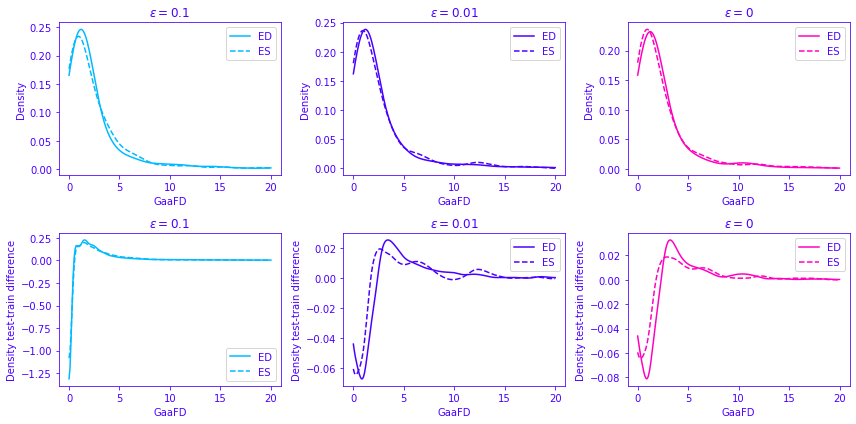

In [59]:
colors = [blue, dark_blue, pink]
x = np.linspace(0, 20, 200)
fig, ax = plt.subplots(ncols=3,nrows=2, figsize=(12, 6))
for i, (test_traj, train_traj) in enumerate(zip(pr_test_traj, pr_train_traj)):
    ed_gaafd_test = gaafd_density(x, test_traj, label=0, bw_method=None)#0.02)
    es_gaafd_test = gaafd_density(x, test_traj, label=1, bw_method=None)#0.02)
    ed_gaafd_train = gaafd_density(x, train_traj, label=0, bw_method=None)#0.02)
    es_gaafd_train = gaafd_density(x, train_traj, label=1, bw_method=None)#0.02)

    ax[0, i].plot(x, ed_gaafd_test, c=colors[i])
    ax[0, i].plot(x, es_gaafd_test, linestyle="dashed", c=colors[i])
    ax[0, i].legend(["ED", "ES"], labelcolor=dark_blue)
    ax[1, i].plot(x, ed_gaafd_test-ed_gaafd_train, c=colors[i])
    ax[1, i].plot(x, es_gaafd_test-es_gaafd_train, linestyle="dashed", c=colors[i])
    ax[1, i].legend(["ED", "ES"], labelcolor=dark_blue)

ax[0,0].set_title("$\epsilon=0.1$", c=dark_blue)
ax[0,0].set_ylabel("Density", c=dark_blue)
ax[0,0].set_xlabel("GaaFD", c=dark_blue)
ax[0,1].set_title("$\epsilon=0.01$", c=dark_blue)
ax[0,1].set_ylabel("Density", c=dark_blue)
ax[0,1].set_xlabel("GaaFD", c=dark_blue)
ax[0,2].set_title("$\epsilon=0$", c=dark_blue)
ax[0,2].set_ylabel("Density", c=dark_blue)
ax[0,2].set_xlabel("GaaFD", c=dark_blue)
ax[1,0].set_title("$\epsilon=0.1$", c=dark_blue)
ax[1,0].set_ylabel("Density test-train difference", c=dark_blue)
ax[1,0].set_xlabel("GaaFD", c=dark_blue)
ax[1,1].set_title("$\epsilon=0.01$", c=dark_blue)
ax[1,1].set_ylabel("Density test-train difference", c=dark_blue)
ax[1,1].set_xlabel("GaaFD", c=dark_blue)
ax[1,2].set_title("$\epsilon=0$", c=dark_blue)
ax[1,2].set_ylabel("Density test-train difference", c=dark_blue)
ax[1,2].set_xlabel("GaaFD", c=dark_blue)
#for i in range(3):
#    ax[0,i].set_ylim([0,0.18])
#    ax[1,i].set_ylim([-0.053,0.016])
for ax in fig.axes:
    ax.tick_params(color=dark_blue, labelcolor=dark_blue)
    for spine in ax.spines.values():
        spine.set_edgecolor(dark_blue)
fig.tight_layout()

### Proximity reward — ES has maybe better performance?
- $\epsilon=0.1$
    - ED: 2.517093561010317
    - ES: 2.4964425471362506
- $\epsilon=0.5$
    - ED: 2.5586623977232303
    - ES: 2.4766275346851656
- $\epsilon=1.0$
    - ED: 2.6657595161864105
    - ES: 2.52230522945571


2.478922091782284
2.4684276058342225
2.1661300158555923
2.193027024201558
2.434827463536108
2.414176449662042
1.8961367239907305
1.9782229540187828
2.5173247954464606
2.5460512273212377
2.015989754848152
2.097042322234419


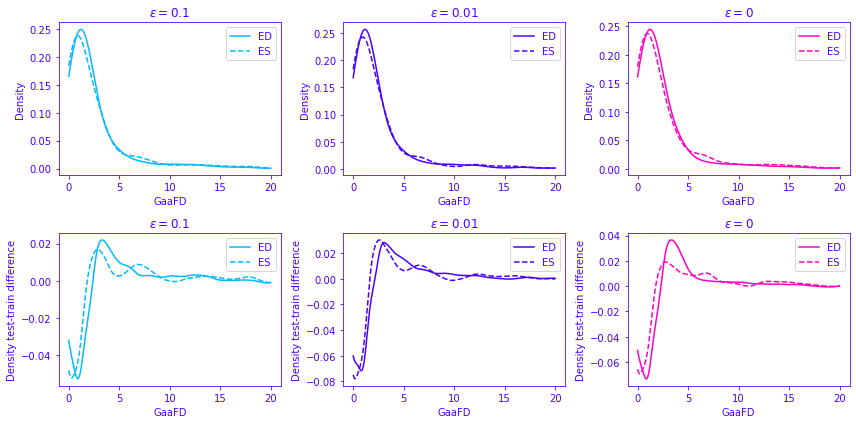

In [60]:
colors = [blue, dark_blue, pink]
x = np.linspace(0, 20, 200)
fig, ax = plt.subplots(ncols=3,nrows=2, figsize=(12, 6))
for i, (test_traj, train_traj) in enumerate(zip(sr_test_traj, sr_train_traj)):
    ed_gaafd_test = gaafd_density(x, test_traj, label=0, bw_method=None)#0.02)
    es_gaafd_test = gaafd_density(x, test_traj, label=1, bw_method=None)#0.02)
    ed_gaafd_train = gaafd_density(x, train_traj, label=0, bw_method=None)#0.02)
    es_gaafd_train = gaafd_density(x, train_traj, label=1, bw_method=None)#0.02)

    ax[0, i].plot(x, ed_gaafd_test, c=colors[i])
    ax[0, i].plot(x, es_gaafd_test, linestyle="dashed", c=colors[i])
    ax[0, i].legend(["ED", "ES"], labelcolor=dark_blue)
    ax[1, i].plot(x, ed_gaafd_test-ed_gaafd_train, c=colors[i])
    ax[1, i].plot(x, es_gaafd_test-es_gaafd_train, linestyle="dashed", c=colors[i])
    ax[1, i].legend(["ED", "ES"], labelcolor=dark_blue)

ax[0,0].set_title("$\epsilon=0.1$", c=dark_blue)
ax[0,0].set_ylabel("Density", c=dark_blue)
ax[0,0].set_xlabel("GaaFD", c=dark_blue)
ax[0,1].set_title("$\epsilon=0.01$", c=dark_blue)
ax[0,1].set_ylabel("Density", c=dark_blue)
ax[0,1].set_xlabel("GaaFD", c=dark_blue)
ax[0,2].set_title("$\epsilon=0$", c=dark_blue)
ax[0,2].set_ylabel("Density", c=dark_blue)
ax[0,2].set_xlabel("GaaFD", c=dark_blue)
ax[1,0].set_title("$\epsilon=0.1$", c=dark_blue)
ax[1,0].set_ylabel("Density test-train difference", c=dark_blue)
ax[1,0].set_xlabel("GaaFD", c=dark_blue)
ax[1,1].set_title("$\epsilon=0.01$", c=dark_blue)
ax[1,1].set_ylabel("Density test-train difference", c=dark_blue)
ax[1,1].set_xlabel("GaaFD", c=dark_blue)
ax[1,2].set_title("$\epsilon=0$", c=dark_blue)
ax[1,2].set_ylabel("Density test-train difference", c=dark_blue)
ax[1,2].set_xlabel("GaaFD", c=dark_blue)
#for i in range(3):
#    ax[0,i].set_ylim([0,0.18])
#    ax[1,i].set_ylim([-0.053,0.016])
for ax in fig.axes:
    ax.tick_params(color=dark_blue, labelcolor=dark_blue)
    for spine in ax.spines.values():
        spine.set_edgecolor(dark_blue)
fig.tight_layout()

### Simple reward — ES has maybe better performance? or??
- $\epsilon=0.1$
    - ED: 2.478922091782284
    - ES: 2.4684276058342225
- $\epsilon=0.5$
    - ED: 2.434827463536108
    - ES: 2.414176449662042
- $\epsilon=1.0$
    - ED: 2.5173247954464606
    - ES: 2.5460512273212377


Simple reward seems to be a tiny bit better than proximity reward — but is this also true if we train on less data?

# Correct number of predictions

Valid aaFD: 1.7063758389261745 0.7929562433297759
Valid aaFD: 1.6892332789559543 0.8025613660618997
Valid aaFD: 1.68125 0.7694770544290288
Valid aaFD: 1.7372881355932204 0.7886872998932764
Valid aaFD: 1.8006700167504188 0.7940234791889007
Valid aaFD: 1.7087813620071686 0.7694770544290288


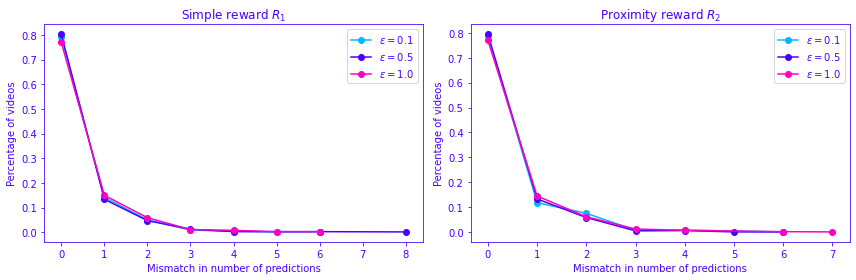

In [68]:
from edesdetectrl.core.metrics import get_events, gaafd
import numpy as np
import matplotlib.pyplot as plt

def valid_aafd(trajectories):
    aafds = []
    n = 0
    event_diffs = []
    for filename, (gt, preds) in trajectories.items():
        gt_events = [e for e in get_events(gt)]
        pred_events = [e for e in get_events(preds)]
        event_diffs.append(np.abs(len(gt_events) - len(pred_events)))
        if len(gt_events) != len(pred_events):
            n+=1
        else:
            aafds.append(gaafd(gt, preds))
    return event_diffs, 1-n/len(trajectories), aafds


colors = [blue, dark_blue, pink]
fig, ax = plt.subplots(ncols=2, figsize=(12,4))
for i, trajectories in enumerate(sr_test_traj):
    event_diffs, p_valid, aafds = valid_aafd(trajectories)
    print("Valid aaFD:", np.mean([aafd for d, aafd in zip(event_diffs, aafds) if d == 0]), p_valid)
    ys_, xs_ = np.histogram(event_diffs, range(120))
    xs_ = xs_[:-1]
    xs, ys = [], []
    for j, y in enumerate(ys_):
        if y != 0:
            ys.append(y)
            xs.append(xs_[j])
    ax[0].plot(xs, np.array(ys)/len(trajectories), "o-", c=colors[i])
for i, trajectories in enumerate(pr_test_traj):
    event_diffs, p_valid, aafds = valid_aafd(trajectories)
    print("Valid aaFD:", np.mean([aafd for d, aafd in zip(event_diffs, aafds) if d == 0]), p_valid)
    ys_, xs_ = np.histogram(event_diffs, range(120))
    xs_ = xs_[:-1]
    xs, ys = [], []
    for j, y in enumerate(ys_):
        if y != 0:
            ys.append(y)
            xs.append(xs_[j])
    ax[1].plot(xs, np.array(ys)/len(trajectories), "o-", c=colors[i])

ax[0].legend(["$\epsilon=0.1$", "$\epsilon=0.5$", "$\epsilon=1.0$"], labelcolor=dark_blue)
ax[0].set_ylabel("Percentage of videos", color=dark_blue)
ax[0].set_xlabel("Mismatch in number of predictions", color=dark_blue)
ax[0].set_title("Simple reward $R_1$", color=dark_blue)
ax[1].legend(["$\epsilon=0.1$", "$\epsilon=0.5$", "$\epsilon=1.0$"], labelcolor=dark_blue)
ax[1].set_ylabel("Percentage of videos", color=dark_blue)
ax[1].set_xlabel("Mismatch in number of predictions", color=dark_blue)
ax[1].set_title("Proximity reward $R_2$", color=dark_blue)
for ax in fig.axes:
    ax.tick_params(color=dark_blue, labelcolor=dark_blue)
    for spine in ax.spines.values():
        spine.set_edgecolor(dark_blue)
fig.tight_layout()

# Representative Q-values

In [76]:
import edesdetectrl.util.dm_env as util_dm_env
from acme import specs
from edesdetectrl.dataloaders.echonet import Echonet
from edesdetectrl.environments.vanilla_binary_classification import (
    VanillaBinaryClassificationBase_v0,
)
from edesdetectrl.nets import simple_dqn_network, transform
from jax import random

from edesdetectrl.dataloaders.echonet import Echonet

base_env = VanillaBinaryClassificationBase_v0("simple")
env = util_dm_env.GymWrapper(base_env)
env_spec = specs.make_environment_spec(env)
network = transform(env_spec, simple_dqn_network(env_spec))


def plot_thing(ax, params_path, key):
    echonet = Echonet(None)
    f, args = echonet[key]
    data_item = f(*args)

    with open(params_path, "rb") as f:
        params, state = pickle.load(f)
    rng_key = random.PRNGKey(1337)

    episode_batch = np.empty((data_item.total_length - 6, 112, 112, 7))
    for frame_index in range(data_item.total_length - 6):
        frames = data_item.video[frame_index: frame_index + 7]
        episode_batch[frame_index] = np.transpose(frames, [1, 2, 0])
    q_values, state = network.apply(params, state, rng_key, episode_batch)

    ax.plot(q_values[:, 0], c=pink)
    ax.plot(q_values[:, 1], c=blue)
    ax.legend(["Diastole value", "Systole value"], labelcolor=dark_blue, loc='lower left')

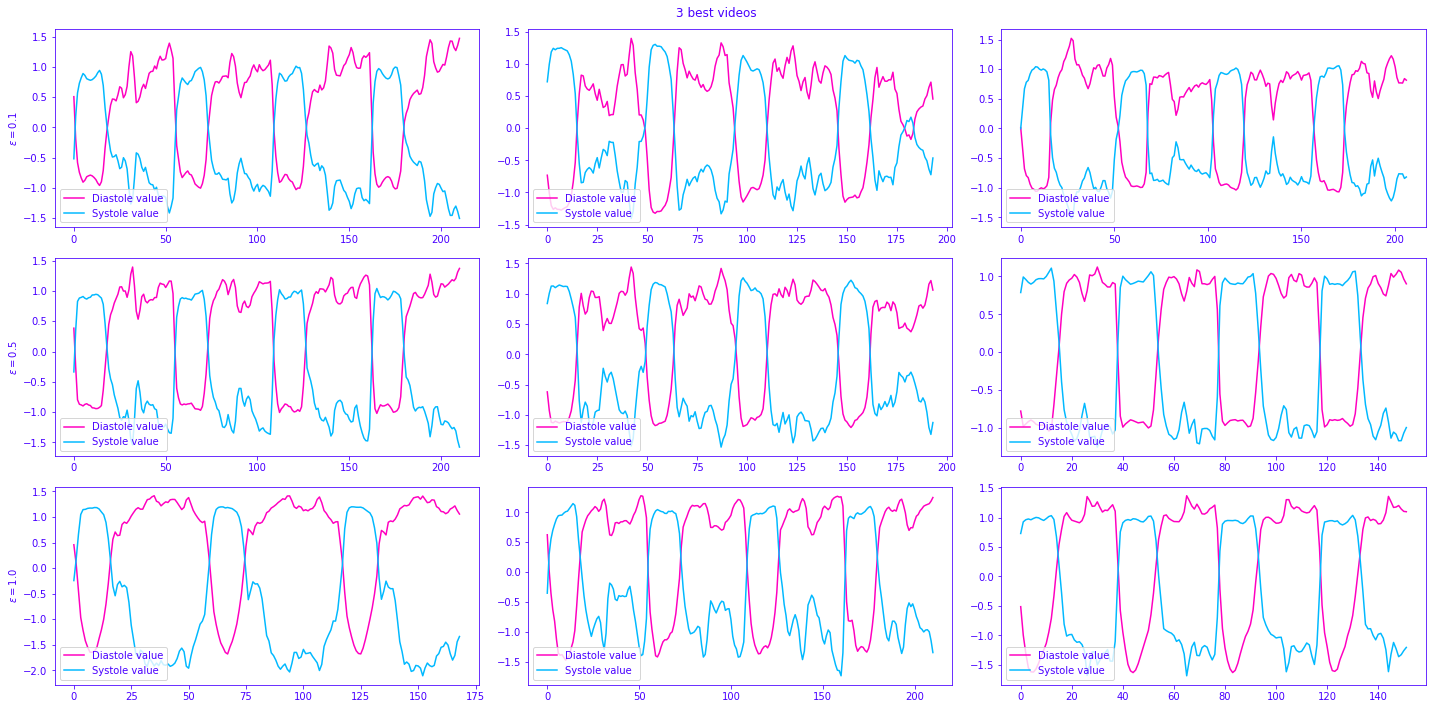

In [78]:
simple_reward_run_ids
proximity_reward_run_ids

params_paths = [
    "notebooks/plots/results/bce/r1r2_rewards/models/" + run_id
    for run_id in simple_reward_run_ids
]

gaafd_sorted = []
for i, trajectories in enumerate(sr_test_traj):
    res = sorted(
        [
            (filename, gaafd(gt, predictions))
            for filename, (gt, predictions) in trajectories.items()
        ],
        key=lambda item: item[1],
    )
    gaafd_sorted.append(res)


fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(20, 10))

for data_i in range(3):
    for model_i, params_path in enumerate(params_paths[::-1]):
        filename, score = gaafd_sorted[model_i][data_i]
        key = filename.split("/")[-1]
        plot_thing(ax[model_i, data_i], params_path, key)

ax[0,0].set_ylabel("$\epsilon=0.1$", color=dark_blue)
ax[1,0].set_ylabel("$\epsilon=0.5$", color=dark_blue)
ax[2,0].set_ylabel("$\epsilon=1.0$", color=dark_blue)
fig.suptitle("3 best videos", color=dark_blue)

fig.tight_layout()
for ax in fig.axes:
    ax.tick_params(color=dark_blue, labelcolor=dark_blue)
    for spine in ax.spines.values():
        spine.set_edgecolor(dark_blue)

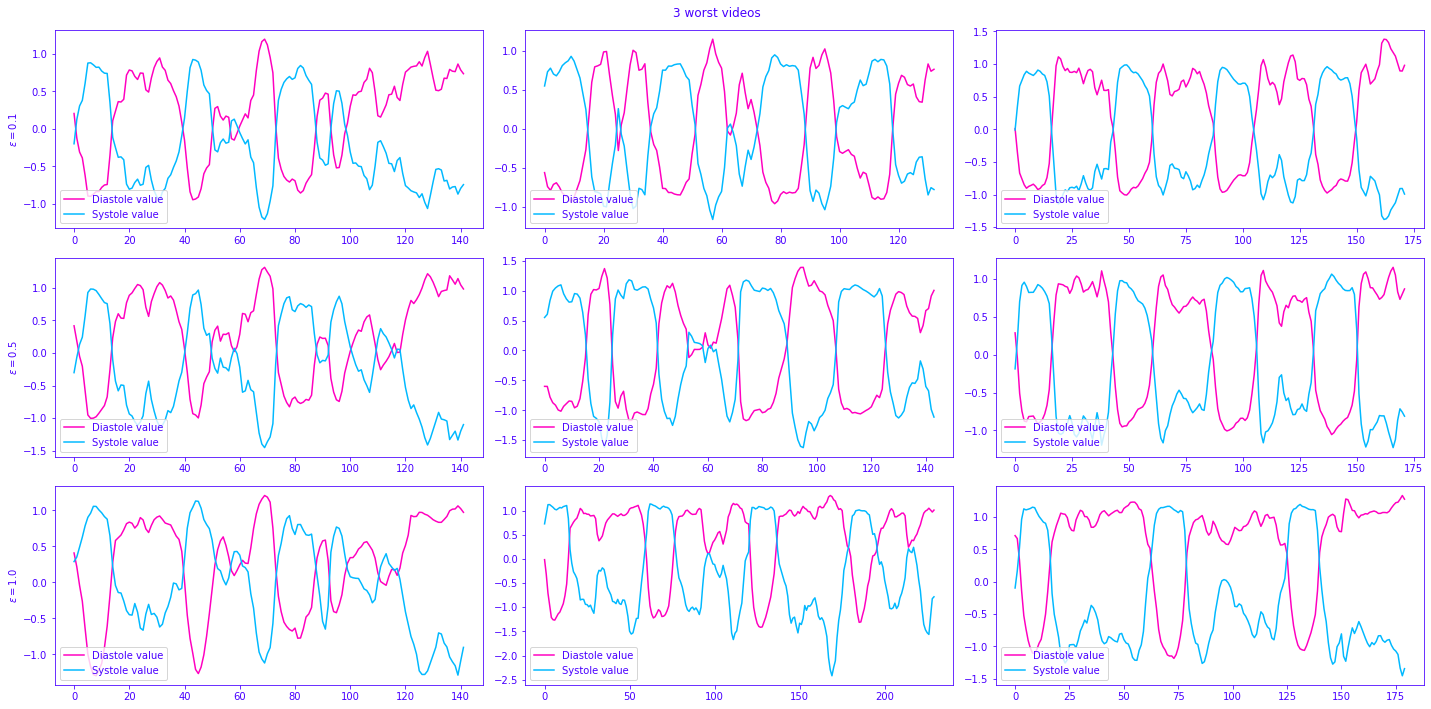

In [87]:
simple_reward_run_ids
proximity_reward_run_ids

params_paths = [
    "notebooks/plots/results/bce/r1r2_rewards/models/" + run_id
    for run_id in simple_reward_run_ids
]

gaafd_sorted = []
for i, trajectories in enumerate(sr_test_traj):
    res = sorted(
        [
            (filename, gaafd(gt, predictions))
            for filename, (gt, predictions) in trajectories.items()
        ],
        key=lambda item: item[1],
    )
    gaafd_sorted.append(res)


fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(20, 10))

for data_i in range(3):
    for model_i, params_path in enumerate(params_paths[::-1]):
        filename, score = gaafd_sorted[model_i][-data_i-1]
        key = filename.split("/")[-1]
        plot_thing(ax[model_i, data_i], params_path, key)

ax[0,0].set_ylabel("$\epsilon=0.1$", color=dark_blue)
ax[1,0].set_ylabel("$\epsilon=0.5$", color=dark_blue)
ax[2,0].set_ylabel("$\epsilon=1.0$", color=dark_blue)
fig.suptitle("3 worst videos", color=dark_blue)

fig.tight_layout()
for ax in fig.axes:
    ax.tick_params(color=dark_blue, labelcolor=dark_blue)
    for spine in ax.spines.values():
        spine.set_edgecolor(dark_blue)

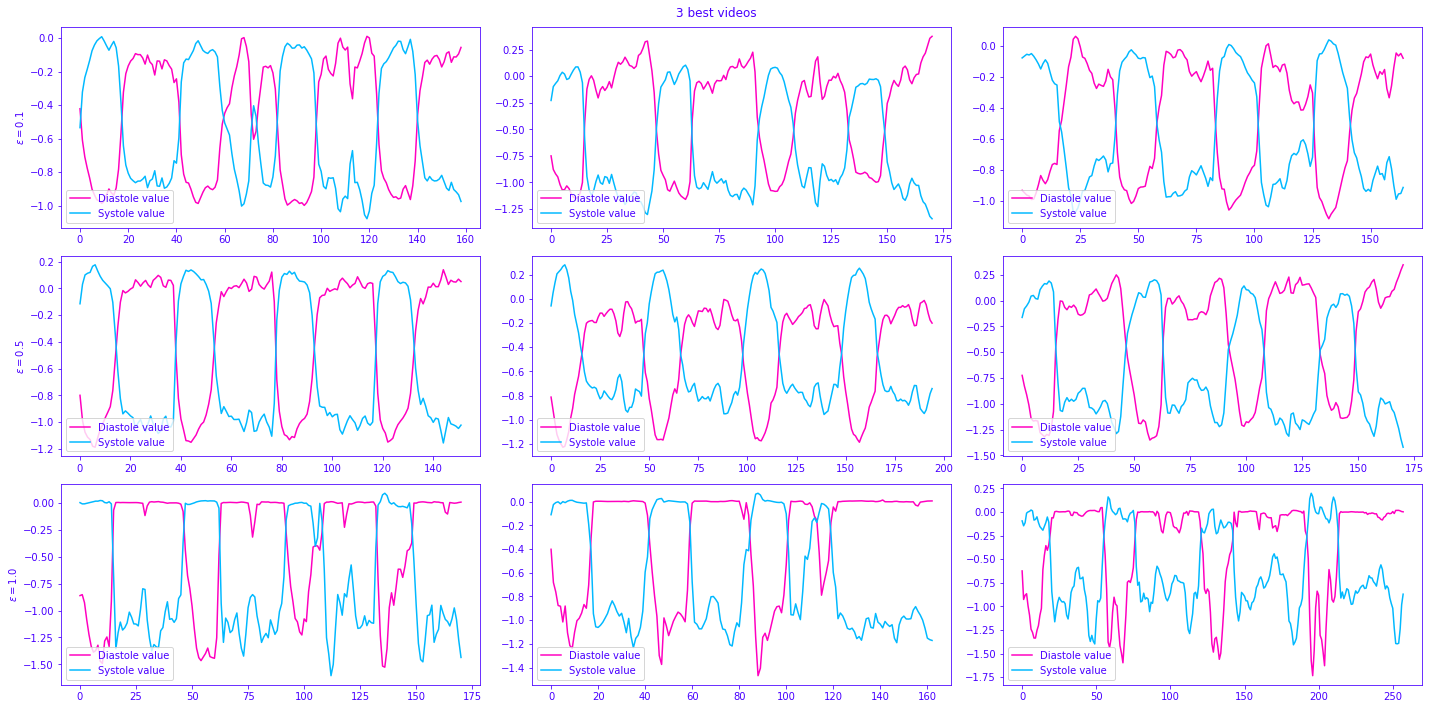

In [86]:
simple_reward_run_ids
proximity_reward_run_ids

params_paths = [
    "notebooks/plots/results/bce/r1r2_rewards/models/" + run_id
    for run_id in proximity_reward_run_ids
]

gaafd_sorted = []
for i, trajectories in enumerate(pr_test_traj):
    res = sorted(
        [
            (filename, gaafd(gt, predictions))
            for filename, (gt, predictions) in trajectories.items()
        ],
        key=lambda item: item[1],
    )
    gaafd_sorted.append(res)


fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(20, 10))

for data_i in range(3):
    for model_i, params_path in enumerate(params_paths[::-1]):
        filename, score = gaafd_sorted[model_i][data_i+2]
        key = filename.split("/")[-1]
        plot_thing(ax[model_i, data_i], params_path, key)

ax[0,0].set_ylabel("$\epsilon=0.1$", color=dark_blue)
ax[1,0].set_ylabel("$\epsilon=0.5$", color=dark_blue)
ax[2,0].set_ylabel("$\epsilon=1.0$", color=dark_blue)
fig.suptitle("3 best videos", color=dark_blue)

fig.tight_layout()
for ax in fig.axes:
    ax.tick_params(color=dark_blue, labelcolor=dark_blue)
    for spine in ax.spines.values():
        spine.set_edgecolor(dark_blue)

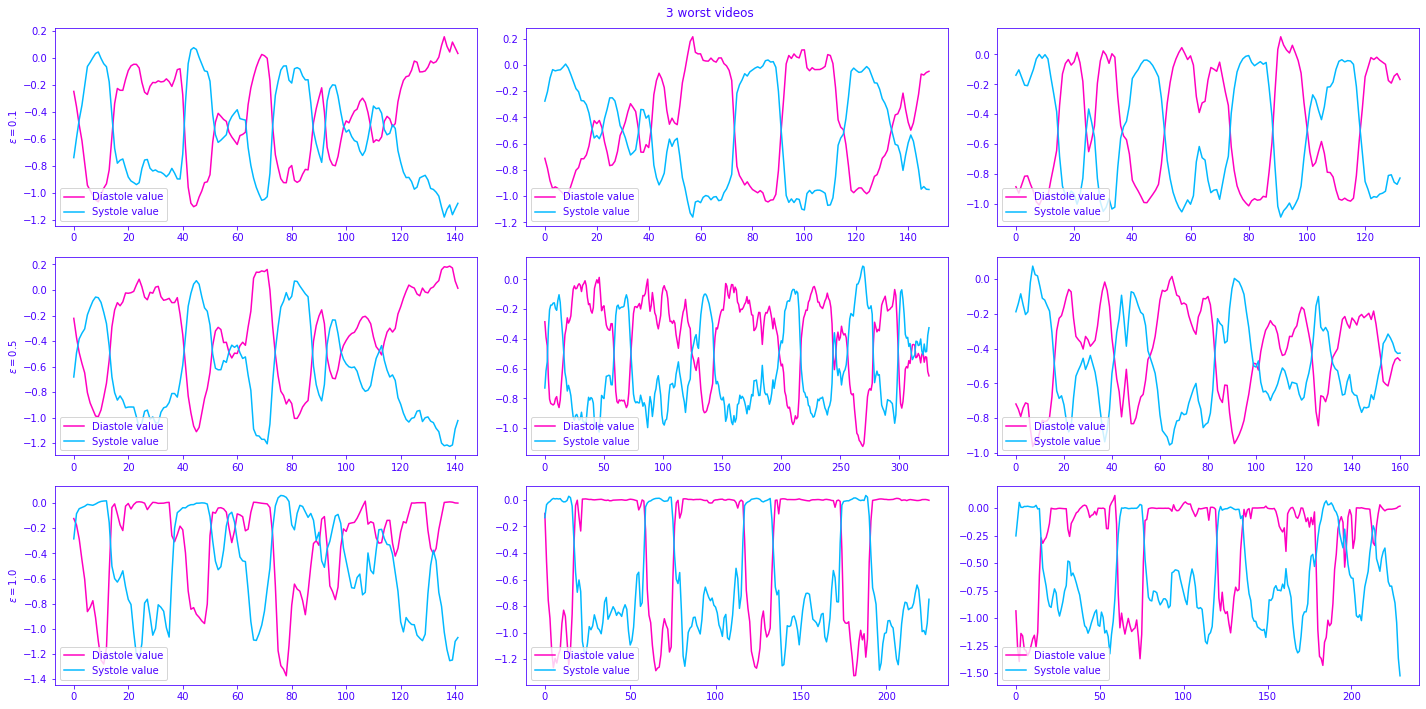

In [88]:
simple_reward_run_ids
proximity_reward_run_ids

params_paths = [
    "notebooks/plots/results/bce/r1r2_rewards/models/" + run_id
    for run_id in proximity_reward_run_ids
]

gaafd_sorted = []
for i, trajectories in enumerate(pr_test_traj):
    res = sorted(
        [
            (filename, gaafd(gt, predictions))
            for filename, (gt, predictions) in trajectories.items()
        ],
        key=lambda item: item[1],
    )
    gaafd_sorted.append(res)


fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(20, 10))

for data_i in range(3):
    for model_i, params_path in enumerate(params_paths[::-1]):
        filename, score = gaafd_sorted[model_i][-data_i-1]
        key = filename.split("/")[-1]
        plot_thing(ax[model_i, data_i], params_path, key)

ax[0,0].set_ylabel("$\epsilon=0.1$", color=dark_blue)
ax[1,0].set_ylabel("$\epsilon=0.5$", color=dark_blue)
ax[2,0].set_ylabel("$\epsilon=1.0$", color=dark_blue)
fig.suptitle("3 worst videos", color=dark_blue)

fig.tight_layout()
for ax in fig.axes:
    ax.tick_params(color=dark_blue, labelcolor=dark_blue)
    for spine in ax.spines.values():
        spine.set_edgecolor(dark_blue)